# Predict Perinatal Health Risk Project
## Data Analysis and Preprocessing
### Task1 - Understanding the Dataset



This dataset includes **1014 records** with no missing values, containing the following columns:

1. 6 independent variables:
- **Age**: Integer
- **SystolicBP**: Integer
- **DiastolicBP**: Integer
- **BS**: Float
- **BodyTemp**: Float
- **HeartRate**: Integer

2. 1 dependent variable:
- **Type**: Categorical variable (with values "low risk", "mid risk", and "high risk") indicating the risk level of the individual.


**Objective**:

Based on the above **6 independent variables**, we need to predict a woman’s maternal health type ("low risk," "mid risk," or "high risk").


**Problem Type: Classification**

This problem is a **classification problem** because:

- The dependent variable **"Type"** has discrete classes, not a continuous value.
- The goal is to predict a **class** based on multiple input features, which aligns with typical classification tasks - sorting instances into categories.


### Task2 - Data Exploration and Pre-processing
#### 1. Analyse the distribution of data between the training and testing sets.
1. We could split the dataset into 80% training and 20% testing. Because our dataset has a reasonable size (1000+ samples),  it’s a good balance between training data size and testing data size. 
2. We can use 80% of the data for training to ensure the model has enough data to learn patterns effectively since more training data helps the model generalise better. 
3. At the same time, we also need enough data for testing in order to accurately assess the model's performance. 20% is suitable for our dataset size.


In [1]:
# import our dataset and libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('Perinatal Risk Information-1.csv')

# Print the first few rows
print(data.head())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate       Type
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


#### 2. Determine whether the dataset is imbalanced. Provide a brief explanation.
From the result of the following cell we can see, the dataset is **slightly imbalanced**. Because our target variable Type has the following distribution in the dataset:

- Low risk: 406 instances
- Mid risk: 336 instances
- High risk: 272 instances

There are more instances of "low risk" compared to "mid risk" and "high risk." 

We have to use stratified splitting after data pre-processing. This ensures that the proportion of each class (e.g., "low risk", "mid risk", "high risk") is similar in both the training and testing sets. This avoids situations where one set contains disproportionately more examples of a particular class, which could bias the results.

Type
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


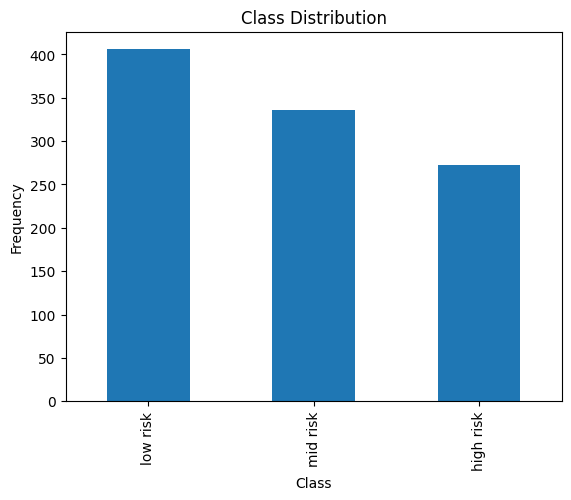

In [2]:
# Check the distribution of the target variable
print(data['Type'].value_counts())

# Plot the distribution
data['Type'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

#### 3. Perform data pre-processing, including handling missing values, feature scaling, and any necessary transformations. Explain why these steps are essential or not required.
##### 1. Handling Missing Values:

There are no missing values in the dataset, so no further steps are required for handling missing data. 

##### 2. Handle noisy data:
- Draw a box plot to detect outliers

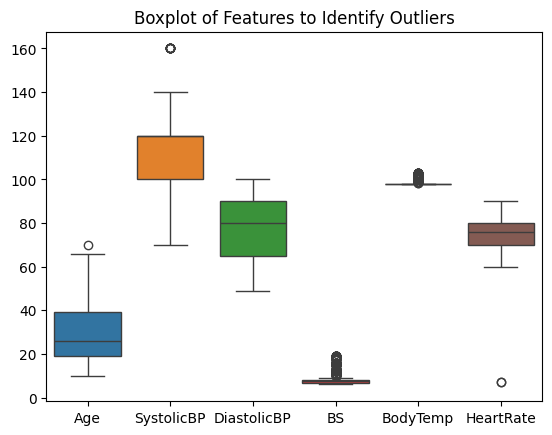

In [4]:
# Handle noisy data
import seaborn as sns
import matplotlib.pyplot as plt

# Draw a box plot to detect outliers
sns.boxplot(data=data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']])
plt.title('Boxplot of Features to Identify Outliers')
plt.show()


- Identify outliers using the Interquartile Range (IQR) method:

from box plot we can see SystolicBP, HeartRate have explicit noisy data. Now we use IQR method to see how many data points we have:

In [5]:
# Calculate the IQR for Age, SystolicBP, and HeartRate
Q1 = data[['SystolicBP', 'HeartRate']].quantile(0.25)
Q3 = data[['SystolicBP', 'HeartRate']].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Identify outliers that are beyond 1.5 times the IQR
outliers = ((data[['SystolicBP', 'HeartRate']] < (Q1 - 1.5 * IQR)) |
            (data[['SystolicBP', 'HeartRate']] > (Q3 + 1.5 * IQR))).sum()

# Print the number of potential outliers in each numeric feature
print("Potential outliers in SystolicBP and HeartRate:")
print(outliers)

# Identify outliers in SystolicBP and HeartRate
outliers = ((data[['SystolicBP', 'HeartRate']] < (Q1 - 1.5 * IQR)) |
            (data[['SystolicBP', 'HeartRate']] > (Q3 + 1.5 * IQR)))

# Filter the dataset to get only the rows that are outliers
outliers_data = data[outliers.any(axis=1)]

# Print the outlier values
print("Outlier values in SystolicBP and HeartRate:")
print(outliers_data[['SystolicBP', 'HeartRate']])



Potential outliers in SystolicBP and HeartRate:
SystolicBP    10
HeartRate      2
dtype: int64
Outlier values in SystolicBP and HeartRate:
     SystolicBP  HeartRate
123         160         77
130         160         77
166         160         77
262         160         77
362         160         77
499         120          7
538         160         77
583         160         77
689         160         77
908         120          7
961         160         77
994         160         77


From the result we can see:
1. Handling of SystolicBP: 

The abnormal data in SystolicBP <= 160. Since 160 mmHg has medical significance, especially for pregnant women with hypertension, it may indicate a high-risk group. Therefore, we retain these data points without deletion or replacement.

2. Handling of HeartRate:

The abnormal data in HeartRate are 7s. The 7 bpm heart rate is clearly invalid, likely due to a measurement or data entry error. We choose to delete these rows because 2 rows don't affect our 1000+ rows sample.

In [10]:
# Remove rows where HeartRate has invalid values (like 7 bpm)
clean_data = data[data['HeartRate'] != 7]

# Print the size of the dataset after removing invalid HeartRate values
print("Data size after removing invalid HeartRate values:", clean_data.shape)


Data size after removing invalid HeartRate values: (1012, 7)


##### 4. Stratified Splitting(after handling data pre-processing):
- use stratified splitting. This ensures that the proportion of each class (e.g., "low risk", "mid risk", "high risk") is similar in both the training and testing sets. This avoids situations where one set contains disproportionately more examples of a particular class, which could bias the results.
- In Scikit-learn, this can be done using the stratify parameter in train_test_split:

In [11]:
# Split the cleaned dataset (using stratify to maintain class balance)
# Define features and target variable
X = clean_data.drop('Type', axis=1)  # Use 'clean_data' instead of 'data'
y = clean_data['Type']

# Split the cleaned dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Output the training set and testing set size
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (809, 6)
Testing set size: (203, 6)



##### 3. Feature Scaling (**ONLY FOR KNN, decision tree doesn't need it**): 

- StandardScaler was applied to the independent variables. This is necessary because features like Age, SystolicBP, and BS have different scales, and many machine learning algorithms (e.g., kNN, logistic regression, and support vector machines) are sensitive to these differences in scale.
- Features with larger ranges (e.g., blood sugar) may dominate features with smaller ranges (e.g., heart rate) if not scaled, which can bias the model's predictions.

In [15]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Apply scaling to the features in both the training and testing sets
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training set
X_test_scaled = scaler.transform(X_test)  # Transform the test set

# Print the first 5 rows of the scaled training data
print("Scaled Training Data (First 5 Rows):")
print(X_train_scaled[:5])

# Print the first 5 rows of the scaled testing data
print("Scaled Testing Data (First 5 Rows):")
print(X_test_scaled[:5])


Scaled Training Data (First 5 Rows):
[[-0.9598295  -0.16057798 -0.10637376  1.29148236  1.70684262  0.19645645]
 [-0.81022887 -1.22889696 -0.82470744 -0.37556166  1.70684262 -0.59754822]
 [-1.4834317  -2.29721593 -1.90220795 -0.557421   -0.48658481 -0.59754822]
 [-0.06222573  0.90774099 -0.4655406  -0.31494187 -0.48658481  0.46112467]
 [-0.51102761  0.37358151  0.97112675 -0.28463198 -0.48658481 -1.92088934]]
Scaled Testing Data (First 5 Rows):
[[-0.66062824  0.37358151  0.25279307 -0.49680122 -0.48658481  0.32879056]
 [-0.81022887  0.37358151  0.61195991  0.07908671 -0.48658481 -1.92088934]
 [-0.36142698  1.44190048  1.68946042 -0.52408012 -0.48658481  0.7257929 ]
 [-1.03462981 -0.69473747 -0.4655406  -0.557421   -0.48658481  0.7257929 ]
 [-0.51102761 -1.22889696 -1.18387427 -0.70897046 -0.48658481  0.19645645]]



##### 4. Transformations:

No additional transformations are required because the target variable Type is already in a suitable format for classification algorithms.

## Model Training and Evaluation
### Task3: Algorithm Selection and Application 
#### **Algorithm 1: Decision Tree**
##### 1. Apply algorithm to the pre-processed dataset.

Directly use the unscaled X_train and X_test for model training and prediction.

##### 2. Provide clear descriptions of the algorithm, citing sources.

**Decision Tree** is a widely used algorithm in machine learning for both classification and regression tasks. It works by recursively splitting the dataset into subsets based on feature values that result in the most significant information gain or Gini index improvement (for classification tasks). The final model is a tree-like structure where each internal node represents a decision based on a feature, and each leaf node represents a class label (for classification) or a value (for regression).

How it works:

The algorithm starts by considering all features and splitting the dataset at each feature based on the value that best separates the target classes (using criteria such as Gini impurity or entropy).
It continues splitting recursively until it reaches a stopping condition, such as reaching a maximum depth or when the splits no longer improve the model’s accuracy.
The result is a tree where each path from the root to a leaf represents a sequence of decisions that lead to a class label.
Advantages:

Simple to understand and interpret.
Requires little data preparation (no need for feature scaling or normalization).
Can handle both numerical and categorical data.
Disadvantages:

Prone to overfitting, especially when the tree is deep.
Small changes in the data can result in a completely different tree.
Not suitable for very large datasets unless pruned or limited in depth.
Cited Sources:

Breiman, L., Friedman, J., Olshen, R., & Stone, C. (1984). Classification and Regression Trees. Chapman & Hall.
Quinlan, J.R. (1986). Induction of decision trees. Machine Learning. 1 (1): 81–106.

In [31]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Create the DecisionTreeClassifier model
decision_tree = DecisionTreeClassifier(random_state=42)

# Step 2: Train the model on the unscaled training data
decision_tree.fit(X_train, y_train)

# Step 3: Make predictions on the unscaled test data
y_pred_dt = decision_tree.predict(X_test)

# Step 4: Evaluate the model's performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy of Decision Tree model:", accuracy_dt)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))


Accuracy of Decision Tree model: 0.8275862068965517
Confusion Matrix:
[[50  0  5]
 [ 1 61 19]
 [ 2  8 57]]
Classification Report:
              precision    recall  f1-score   support

   high risk       0.94      0.91      0.93        55
    low risk       0.88      0.75      0.81        81
    mid risk       0.70      0.85      0.77        67

    accuracy                           0.83       203
   macro avg       0.84      0.84      0.84       203
weighted avg       0.84      0.83      0.83       203



##### 3. Hyperparameter Tuning:

Perform hyperparameter tuning for at least one algorithm. Discuss how tuning the hyperparameters affected your model’s performance.

Hyperparameter tuning involves adjusting the hyperparameters of a model to optimize its performance. For a Decision Tree Classifier, the most important hyperparameters to tune include:

max_depth: The maximum depth of the tree. Limiting the depth of the tree prevents overfitting by controlling the complexity of the model.
min_samples_split: The minimum number of samples required to split an internal node. Increasing this value can also prevent overfitting by stopping the model from learning overly specific patterns.
min_samples_leaf: The minimum number of samples that must be present in a leaf node. This parameter can prevent the model from creating small, specific leaf nodes, reducing overfitting.
criterion: The function to measure the quality of a split (e.g., gini for Gini impurity, entropy for information gain).

We can use Grid Search or Randomized Search for hyperparameter tuning in Scikit-learn. Grid Search exhaustively tests all combinations of hyperparameters, while Randomized Search samples from a range of hyperparameter values.

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_dt = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 3, 4, 5, 10],  
    'min_samples_leaf': [1, 2, 4, 5, 10],  
    'criterion': ['gini', 'entropy'],  
}

# Initialize the decision tree classifier
tuned_decision_tree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(estimator=tuned_decision_tree, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search_dt.fit(X_train, y_train)

# Get the best parameters and model
best_params_dt = grid_search_dt.best_params_
print("Best Hyperparameters for Decision Tree:", best_params_dt)
best_dt_model = grid_search_dt.best_estimator_

# Evaluate the tuned model
y_pred_tuned_dt = best_dt_model.predict(X_test)

# Evaluate the tuned decision tree model's performance
accuracy_tuned_dt = accuracy_score(y_test, y_pred_tuned_dt)
print("Accuracy of Tuned Decision Tree:", accuracy_tuned_dt)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned_dt))
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned_dt))




Best Hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy of Tuned Decision Tree: 0.8374384236453202
Confusion Matrix:
[[51  1  3]
 [ 6 60 15]
 [ 2  6 59]]
Classification Report:
              precision    recall  f1-score   support

   high risk       0.86      0.93      0.89        55
    low risk       0.90      0.74      0.81        81
    mid risk       0.77      0.88      0.82        67

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203



#### **Algorithm 2: kNN**
##### 1. Apply algorithm to the pre-processed dataset.
##### 2. Provide clear descriptions of the algorithms, citing sources.

K-Nearest Neighbors (KNN) is a simple, non-parametric, and instance-based learning algorithm primarily used for classification and regression tasks. It is a type of lazy learning algorithm because it does not explicitly learn a model during the training phase. Instead, KNN defers the computation to the time of prediction.

How KNN Works:
Distance Calculation: For a given data point, the algorithm calculates the distance between this point and all other points in the training dataset. Common distance metrics include:

Euclidean Distance: The most commonly used metric for continuous features. It measures the straight-line distance between two points.
$$d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$
 
Manhattan Distance: The sum of absolute differences between two points, useful for grid-like data.
$$d(x, y) = \sum_{i=1}^{n} |x_i - y_i|$$


Minkowski Distance: A generalization of both Euclidean and Manhattan distances.
Selecting K Neighbors: Once the distances are calculated, the algorithm selects the k nearest neighbors (smallest distances) to the point of interest. The choice of k is a hyperparameter:

If k is too small (e.g., k=1), the algorithm may be too sensitive to noise and overfit.
If k is too large, the algorithm might underfit because it averages over a large number of neighbors.
Majority Voting (Classification): For classification tasks, KNN assigns a class label based on the majority class among the k nearest neighbors. In other words, it looks at the most common class in the neighborhood of the point.

Averaging (Regression): For regression tasks, KNN returns the average of the values of the k nearest neighbors.

Advantages of KNN:
Simple to understand and easy to implement.
No training phase: Since it’s an instance-based learning method, KNN stores the entire dataset, and computations are deferred until prediction time.
Flexible: Can be used for both classification and regression.

Disadvantages of KNN:
Computationally expensive: As the dataset grows, the time complexity for distance calculation grows because the algorithm needs to compute the distance for each point in the training set.
Sensitive to the choice of k: A poor choice of k can lead to underfitting or overfitting.
Sensitive to the scale of data: KNN is a distance-based algorithm, so features with larger scales will dominate the distance calculation. Therefore, feature scaling (e.g., standardization) is often required before applying KNN.

Sources:
Aggarwal, Charu C. Data Classification: Algorithms and Applications. CRC Press, 2014.
Hastie, Trevor, et al. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Science & Business Media, 2009.
Kramer, Olaf. "K-Nearest Neighbors." In Dimensionality Reduction with Unsupervised Nearest Neighbors, pp. 13-23. Springer, 2013.
In summary, KNN is a powerful but simple algorithm suitable for various tasks, especially when quick and interpretable results are needed. However, its performance can degrade with large datasets and unscaled features, and it requires careful hyperparameter tuning for optimal results.

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model with k=5 (n_neighbors=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model using the scaled training data
knn.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing data
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the KNN model's performance
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy of KNN model:", accuracy_knn)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))



Accuracy of KNN model: 0.6699507389162561
Confusion Matrix:
[[39  6 10]
 [ 4 56 21]
 [ 2 24 41]]
Classification Report:
              precision    recall  f1-score   support

   high risk       0.87      0.71      0.78        55
    low risk       0.65      0.69      0.67        81
    mid risk       0.57      0.61      0.59        67

    accuracy                           0.67       203
   macro avg       0.70      0.67      0.68       203
weighted avg       0.68      0.67      0.67       203



##### 3. Hyperparameter Tuning: 

Perform hyperparameter tuning for at least one algorithm. Discuss how tuning the hyperparameters affected your model’s performance.

Tuning hyperparameters in K-Nearest Neighbors (KNN) has a significant impact on the model's performance because KNN relies heavily on parameters like k (n_neighbors), the distance metric, and the weighting of neighbors. These hyperparameters define how the model interprets the data and influences its predictions.

Let’s break down the impact of each hyperparameter and how it can affect the performance of the KNN model:

1. n_neighbors (k value)
Effect on Performance:

A small k value (e.g., k=1) means the model will rely on just one nearest neighbor to make predictions. While this can capture local patterns, it makes the model more sensitive to noise, leading to potential overfitting. The model may predict well on the training data but struggle on the test data due to its sensitivity to outliers or noisy points.
A larger k value (e.g., k=10 or more) reduces the influence of individual noisy points by averaging over more neighbors. This can lead to better generalization on unseen data but risks underfitting if k becomes too large, as the model may become overly smooth and fail to capture local patterns.
Performance Impact:

Small k: Likely to result in higher accuracy on training data but may perform poorly on test data due to overfitting.
Larger k: Smoother decision boundaries lead to better generalization on test data, though too large a k might underfit the data.

2. metric (Distance Metric)
Effect on Performance:

The choice of distance metric determines how the model measures "closeness" between points, which is fundamental to the KNN algorithm. Different metrics may be better suited for different types of data:
Euclidean distance tends to work well when features are continuous and fairly independent.
Manhattan distance may be more appropriate for grid-like data (e.g., city block distances) or when features are strongly correlated along certain axes.
Minkowski distance generalizes Euclidean and Manhattan distances and allows the model to adjust its sensitivity using the p parameter.
Chebyshev distance measures the maximum difference along any coordinate, which can be useful when the maximum difference across any axis matters most (e.g., in some logistical problems).
Performance Impact:

Euclidean often works well with continuous data, leading to stable and reasonable results.
Manhattan may perform better on data where features exhibit correlations or where distances must be summed along multiple dimensions.
Tuning the distance metric can significantly improve performance when the default metric doesn’t capture the true relationships in the data.

3. weights (Neighbor Weights)
Effect on Performance:

The weights parameter controls how the nearest neighbors influence the prediction. With 'uniform', each neighbor contributes equally, while with 'distance', closer neighbors contribute more.
Distance-based weights are particularly helpful in situations where the closest points are likely to be more relevant to the prediction than farther points. On the other hand, uniform weights can be useful when all neighbors are expected to be equally important.
Performance Impact:

'uniform' weights: If all neighbors are equally relevant, this can produce good results. However, in scenarios where proximity is important, this might result in a less accurate model.
'distance' weights: This can lead to better performance when closer neighbors are more important. It helps to reduce the influence of distant, less relevant neighbors and thus can lead to improved accuracy, particularly in noisy data.

4. p (Minkowski Distance Parameter)
Effect on Performance:

When using Minkowski distance, tuning the p parameter allows us to adjust how the distance is computed. If p=1, the model uses Manhattan distance; if p=2, it uses Euclidean distance. Tuning this parameter lets us explore the sensitivity of the model to different types of distances.
Performance Impact:
p=1 (Manhattan) may work better for grid-like or high-dimensional data.
p=2 (Euclidean) is generally more appropriate for continuous, less structured data.
Observing the Impact:
Before Tuning: The model likely had a default setting of k=5, using Euclidean distance and uniform weighting. While this configuration can yield decent results, it may not be optimal for our specific dataset.

After Tuning: By testing multiple values of k, different distance metrics, and weighting schemes, the model can achieve better accuracy on unseen data. The best-performing hyperparameters depend on the dataset's characteristics:

A better k value might reduce overfitting or underfitting.
The most suitable distance metric aligns better with the underlying data structure.
Using distance-based weights can reduce the influence of distant, less-relevant neighbors.


In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to tune 'metric' and 'weights'
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Tune different values for k
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],  # Distance metrics to try
    'weights': ['uniform', 'distance'],  # Neighbor weighting schemes
    'p': [1, 2]  # p parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# Initialize the KNN classifier
tuned_knn = KNeighborsClassifier()

# Use GridSearchCV to tune the hyperparameters
grid_search_knn = GridSearchCV(estimator=tuned_knn, param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search_knn.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_knn = grid_search_knn.best_params_
print("Best Hyperparameters for KNN:", best_params_knn)

# Use the best KNN model to make predictions
best_knn_model = grid_search_knn.best_estimator_
y_pred_tuned_knn = best_knn_model.predict(X_test_scaled)

# Evaluate the tuned KNN model
accuracy_tuned_knn = accuracy_score(y_test, y_pred_tuned_knn)
print("Accuracy of Best KNN model:", accuracy_tuned_knn)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned_knn))




Best Hyperparameters for KNN: {'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Accuracy of Best KNN model: 0.8029556650246306
Confusion Matrix:
[[50  2  3]
 [ 3 55 23]
 [ 1  8 58]]
Classification Report:
              precision    recall  f1-score   support

   high risk       0.93      0.91      0.92        55
    low risk       0.85      0.68      0.75        81
    mid risk       0.69      0.87      0.77        67

    accuracy                           0.80       203
   macro avg       0.82      0.82      0.81       203
weighted avg       0.82      0.80      0.80       203



### Task4: Model Evaluation and Comparative Analysis
##### 1. Train and test your chosen algorithms using the training and testing sets.

Two algorithms, Decision Tree and K-Nearest Neighbors (KNN), were trained using the cleaned training dataset. Hyperparameter tuning was performed on both models to enhance performance.

##### 2. Evaluate the models using appropriate performance metrics (e.g., accuracy,  confusion matrix).

For each model, the accuracy, confusion matrix, and classification report (with precision, recall, and F1-score) were used to evaluate performance.

#### **Algorithm 1: Decision Tree**

- Decision Tree Model (before tuning):

<img src="/Users/wulin/Desktop/SDD-2024/Intro-to-ML/predict-perinatal-health-risk/decision_tree_result.png" alt="Confusion Matrix" width="600"/>

Accuracy: 82.76%

Classification Report showed high precision for "high risk" but mid performance for "mid risk" with a precision of 0.70.

- Tuned Decision Tree Model (after tuning):

<img src="/Users/wulin/Desktop/SDD-2024/Intro-to-ML/predict-perinatal-health-risk/tuned_decision_tree_result.png" width="1100"/>

Accuracy: 83.74%

Precision for "mid risk" improved to 0.77 after hyperparameter tuning, with slight performance improvements overall.

#### **Algorithm 2: kNN**

- KNN Model (before tuning):

<img src="/Users/wulin/Desktop/SDD-2024/Intro-to-ML/predict-perinatal-health-risk/knn_result.png" width="600"/>

Accuracy: 66.99%

Precision for "high risk" was decent (0.87), but "mid risk" suffered with only 0.57 in precision and 0.59 in F1-score.

- Best KNN Model (after tuning):

<img src="/Users/wulin/Desktop/SDD-2024/Intro-to-ML/predict-perinatal-health-risk/tuned_knn_result.png" width="900"/>

Accuracy: 80.30%

Precision for "mid risk" significantly improved to 0.69, and overall model performance improved due to better distance metrics and weighting.

##### 3. Present the results, including any visualizations or graphs that help demonstrate performance differences.



In [45]:
# Metrics for Decision Tree (Un-tuned)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Metrics for Decision Tree (Tuned)
accuracy_dt_tuned = accuracy_score(y_test, y_pred_tuned_dt)
report_dt_tuned = classification_report(y_test, y_pred_tuned_dt, output_dict=True)

# Metrics for KNN (Un-tuned)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

# Metrics for KNN (Tuned)
accuracy_knn_tuned = accuracy_score(y_test, y_pred_tuned_knn)
report_knn_tuned = classification_report(y_test, y_pred_tuned_knn, output_dict=True)

# Store them in a dictionary or DataFrame for easy comparison
model_metrics = {
    'Model': ['Decision Tree', 'Tuned Decision Tree', 'KNN', 'Tuned KNN'],
    'Accuracy': [accuracy_dt, accuracy_dt_tuned, accuracy_knn, accuracy_knn_tuned],
    'Precision (High Risk)': [report_dt['high risk']['precision'], report_dt_tuned['high risk']['precision'], report_knn['high risk']['precision'], report_knn_tuned['high risk']['precision']],
    'Recall (High Risk)': [report_dt['high risk']['recall'], report_dt_tuned['high risk']['recall'], report_knn['high risk']['recall'], report_knn_tuned['high risk']['recall']],
    'F1-Score (High Risk)': [report_dt['high risk']['f1-score'], report_dt_tuned['high risk']['f1-score'], report_knn['high risk']['f1-score'], report_knn_tuned['high risk']['f1-score']]
}

# Convert the dictionary to a DataFrame
import pandas as pd
comparison_df = pd.DataFrame(model_metrics)
print(comparison_df)




                 Model  Accuracy  Precision (High Risk)  Recall (High Risk)  \
0        Decision Tree  0.827586               0.943396            0.909091   
1  Tuned Decision Tree  0.837438               0.864407            0.927273   
2                  KNN  0.669951               0.866667            0.709091   
3            Tuned KNN  0.802956               0.925926            0.909091   

   F1-Score (High Risk)  
0              0.925926  
1              0.894737  
2              0.780000  
3              0.917431  


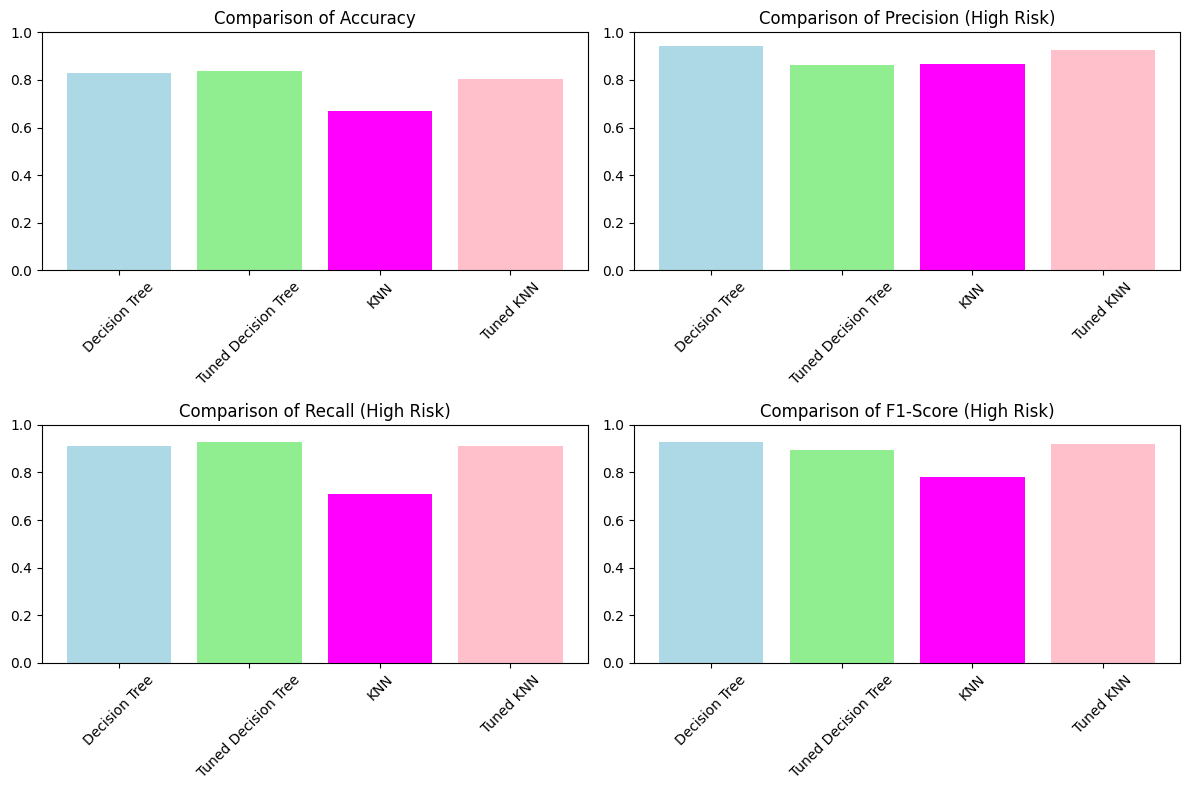

In [54]:
import matplotlib.pyplot as plt

# Plot comparison for accuracy, precision, recall, and F1-score
metrics = ['Accuracy', 'Precision (High Risk)', 'Recall (High Risk)', 'F1-Score (High Risk)']

# Plotting the metrics
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.bar(comparison_df['Model'], comparison_df[metric], color=['lightblue', 'lightgreen', 'magenta', 'pink'])
    plt.title(f'Comparison of {metric}')
    plt.ylim(0, 1)  # Since all metrics range from 0 to 1
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


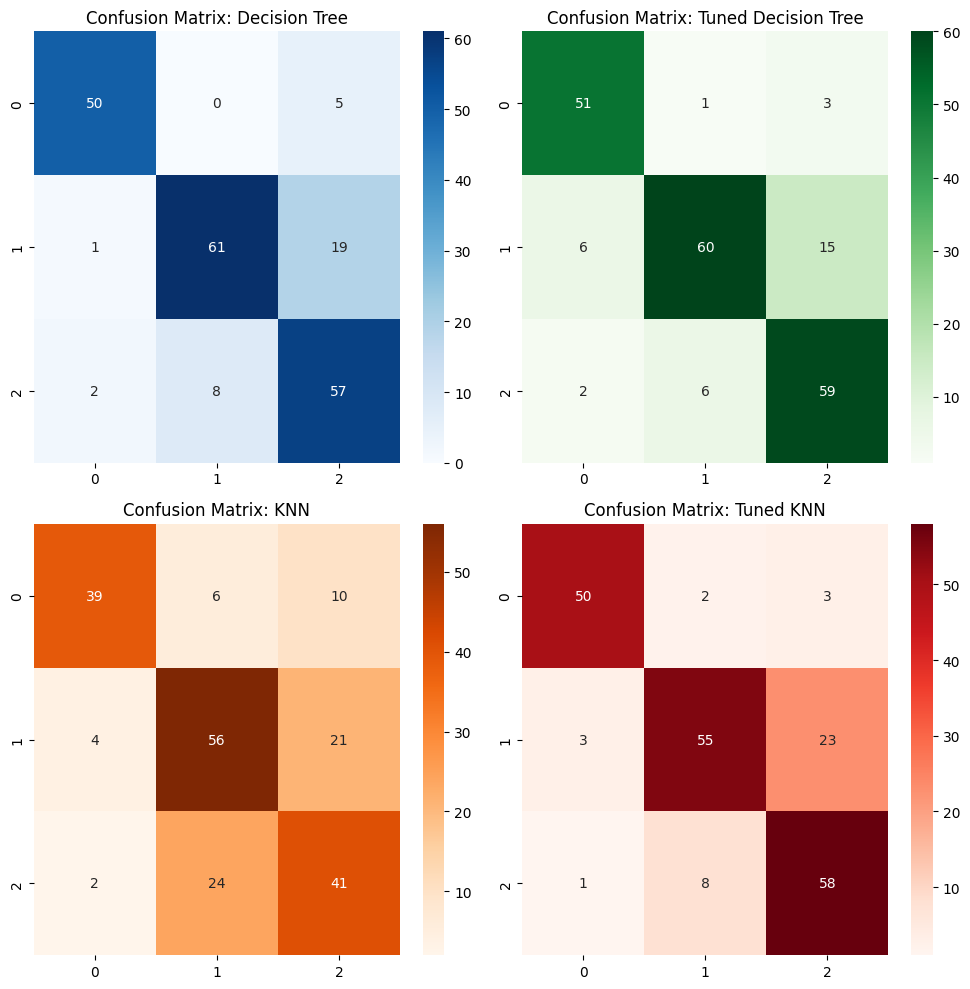

In [48]:
import seaborn as sns

# Assuming confusion matrices have been calculated for all models
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt_tuned = confusion_matrix(y_test, y_pred_tuned_dt)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_tuned = confusion_matrix(y_test, y_pred_tuned_knn)

# Create subplots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot each confusion matrix
sns.heatmap(cm_dt, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title("Confusion Matrix: Decision Tree")

sns.heatmap(cm_dt_tuned, annot=True, fmt='d', ax=axes[0, 1], cmap='Greens')
axes[0, 1].set_title("Confusion Matrix: Tuned Decision Tree")

sns.heatmap(cm_knn, annot=True, fmt='d', ax=axes[1, 0], cmap='Oranges')
axes[1, 0].set_title("Confusion Matrix: KNN")

sns.heatmap(cm_knn_tuned, annot=True, fmt='d', ax=axes[1, 1], cmap='Reds')
axes[1, 1].set_title("Confusion Matrix: Tuned KNN")

# Display the plot
plt.tight_layout()
plt.show()



##### **Conclusion**:
1. Decision Tree models are more accurate than KNN for this dataset.

2. Hyperparameter tuning improves model performance, especially in the recall and precision metrics for the critical high-risk class.

3. KNN benefits significantly from tuning in terms of classification accuracy and the confusion matrix, but still does not outperform the Decision Tree models.

These comparisons reveal that Decision Tree models (with and without tuning) are the most effective for classifying this dataset, while KNN benefits from tuning but may not be the best algorithm for this task.

##### 4. Compare both models' performances. Discuss whether the models provided similar or significantly different results and explain why.

Decision Tree vs KNN:

Before tuning, Decision Tree significantly outperformed KNN, especially in predicting "mid risk" and "low risk."
After tuning, KNN's performance improved substantially, closing the gap in accuracy with Decision Tree. The best KNN model achieved 80.30% accuracy, while the Decision Tree maintained a slight edge at 83.74%.

Reason for Differences:

Decision Trees excel in handling categorical and continuous features without needing scaling, whereas KNN relies heavily on feature scaling and distance calculations, which could lead to initial poorer performance.
Tuning distance metrics (e.g., Chebyshev) and weighting schemes in KNN helped improve its performance, especially for the "mid risk" class.

In conclusion, both models showed reasonable performance after tuning, with Decision Tree slightly outperforming KNN. However, KNN's performance improved significantly with appropriate tuning, making it a competitive model for this classification task.

## Ethical Considerations
### 1. Reflect on the ethical implications of using machine learning models in healthcare, particularly in the context of predicting maternal health risks.

- Machine learning in healthcare, especially for predicting maternal health risks, brings both potential benefits and ethical challenges:

- Accuracy: Incorrect predictions could lead to harmful decisions, such as unnecessary treatments or missed risks.

- Transparency: Black-box models make it hard for healthcare providers to understand how decisions are made, leading to trust issues.

- Fairness: If trained on biased data, models could disproportionately affect certain groups, worsening healthcare inequalities.



### 2. Discuss potential biases, risks, and ethical concerns associated with using these models in real-world healthcare settings.

- Data Bias: If training data isn't representative of all populations, predictions could be biased, leading to unfair treatment of certain groups.

- Over-reliance: Clinicians may overly depend on models, risking wrong decisions if predictions conflict with medical judgment.

- Accountability: If a model's prediction harms a patient, it's unclear who is responsible—the developer, healthcare provider, or institution.

- Access Disparities: Unequal access to ML tools could widen healthcare gaps, benefiting wealthier institutions over underfunded ones.


